In [1]:
import sqlite3
import pandas as pd
conn = sqlite3.connect("Chinook_Sqlite.sqlite")
cursor = conn.cursor()

## 1 Basic SQL Queries
**(a) The names of all tracks longer than 15 minutes. Sort the results by TrackId and return the first 10 songs.**

In [2]:
result = pd.read_sql_query("SELECT Name FROM Track WHERE Milliseconds >= 900000 ORDER BY TrackID LIMIT 10", conn)
result

,Name
0,My Funny Valentine (Live)
1,Space Truckin'
2,Going Down / Highway Star
3,Dazed And Confused
4,Dazed And Confused
5,We've Got To Get Together/Jingo
6,Funky Piano
7,Battlestar Galactica: The Story So Far
8,Occupation / Precipice
9,"Exodus, Pt. 1"


**(b) The customer who bought the least amount of tracks. Return the customer name.**

In [3]:
result = pd.read_sql_query("SELECT Customer.FirstName, Customer.LastName \
                            FROM Invoice, Customer \
                            WHERE Invoice.CustomerId = Customer.CustomerId \
                            GROUP BY Invoice.CustomerId \
                            ORDER BY COUNT(Invoice.CustomerId) Limit 1", conn)
result

,FirstName,LastName
0,Puja,Srivastava


**(c) Find all artists that have more than five albums, return the name and the count of their albums.**

In [4]:
 result = pd.read_sql_query("SELECT Name,Count\
                            FROM(SELECT Name, COUNT(ArtistId) AS Count\
                            FROM (SELECT * FROM Artist, Album\
                            WHERE Artist.ArtistId = Album.ArtistId)\
                            GROUP BY ArtistId)\
                            WHERE Count > 5", conn)
result

,Name,Count
0,Led Zeppelin,14
1,Metallica,10
2,Deep Purple,11
3,Iron Maiden,21
4,Ozzy Osbourne,6
5,U2,10


**(d) Find the albums that appear on more than 5 playlists (> 5). Return the album name and number of playlists they appear on.**

In [5]:
cursor.execute("CREATE TEMPORARY TABLE TMP AS\
                SELECT * \
                FROM Album, Track, PlaylistTrack \
                WHERE (PlaylistTrack.TrackId = Track.TrackId AND Track.AlbumId = Album.AlbumId)")
result = pd.read_sql_query("SELECT Title, Count \
                            FROM (SELECT Title, COUNT(PlaylistId) AS Count \
                            FROM (SELECT AlbumId, Title, PlaylistId FROM TMP GROUP BY AlbumId, PlaylistId) \
                            GROUP BY AlbumId) \
                            WHERE Count > 5", conn)
result

,Title,Count
0,The World of Classical Favourites,6
1,English Renaissance,6


## 2 Clustering Artists
**In this question, you will gather information on the artists and their tracks, and then cluster the artists into groups.**

**(a) Write an SQL query to gather information about the artists, their albums, tracks, genres, and playlists. Import this information into a pandas
data frame. (Note: you can do this in one big join.) Please include the following columns:<br>
• [PlaylistId][TrackId][TrackName][AlbumId][MediaTypeId]<br>
• [GenreId][Composer][Milliseconds][Bytes][UnitPrice]<br>
• [GenreName][AlbumTitle][ArtistId][ArtistName]<br>
Their order and naming do not matter.**

In [6]:
df = pd.read_sql_query("SELECT Track.*, Album.Title AS AlbumTitle, Artist.ArtistId, Artist.Name AS ArtistName, \
                    Genre.Name AS GenreName, PlaylistTrack.PlaylistId \
                    FROM Track, PlaylistTrack, Album, Artist, Genre \
                    WHERE (Track.AlbumId = Album.AlbumId AND Album.ArtistId = Artist.ArtistId AND \
                    Track.TrackId = PlaylistTrack.TrackId AND Genre.GenreId = Track.GenreId)", conn)
df

,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice,AlbumTitle,ArtistId,ArtistName,GenreName,PlaylistId
0,3402,"Band Members Discuss Tracks from ""Revelations""",271,3,23,None,294294,61118891,0.99,Revelations,8,Audioslave,Alternative,1
1,3389,Revelations,271,2,23,None,252376,4111051,0.99,Revelations,8,Audioslave,Alternative,1
2,3390,One and the Same,271,2,23,None,217732,3559040,0.99,Revelations,8,Audioslave,Alternative,1
3,3391,Sound of a Gun,271,2,23,None,260154,4234990,0.99,Revelations,8,Audioslave,Alternative,1
4,3392,Until We Fall,271,2,23,None,230758,3766605,0.99,Revelations,8,Audioslave,Alternative,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8710,2094,I Don't Know,171,2,1,"B. Daisley, O. Osbourne & R. Rhoads",312980,5525339,0.99,Blizzard of Ozz,114,Ozzy Osbourne,Rock,17
8711,2095,Crazy Train,171,2,1,"B. Daisley, O. Osbourne & R. Rhoads",295960,5255083,0.99,Blizzard of Ozz,114,Ozzy Osbourne,Rock,17
8712,2096,Flying High Again,172,2,1,"L. Kerslake, O. Osbourne, R. Daisley & R. Rhoads",290851,5179599,0.99,Diary of a Madman (Remastered),114,Ozzy Osbourne,Rock,17
8713,3290,The Zoo,257,2,1,None,332740,5550779,0.99,20th Century Masters - The Millennium Collecti...,179,Scorpions,Rock,17


**(b) Select all the artists that have more than one album (> 1) for the analysis below.**

In [7]:
grouped = df.groupby('ArtistId')
over_one = grouped.filter(lambda x : x.AlbumId.nunique() > 1)
over_one

,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice,AlbumTitle,ArtistId,ArtistName,GenreName,PlaylistId
0,3402,"Band Members Discuss Tracks from ""Revelations""",271,3,23,None,294294,61118891,0.99,Revelations,8,Audioslave,Alternative,1
1,3389,Revelations,271,2,23,None,252376,4111051,0.99,Revelations,8,Audioslave,Alternative,1
2,3390,One and the Same,271,2,23,None,217732,3559040,0.99,Revelations,8,Audioslave,Alternative,1
3,3391,Sound of a Gun,271,2,23,None,260154,4234990,0.99,Revelations,8,Audioslave,Alternative,1
4,3392,Until We Fall,271,2,23,None,230758,3766605,0.99,Revelations,8,Audioslave,Alternative,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8706,1880,Creeping Death,154,1,3,Metallica,396878,12955593,0.99,Ride The Lightning,50,Metallica,Metal,17
8710,2094,I Don't Know,171,2,1,"B. Daisley, O. Osbourne & R. Rhoads",312980,5525339,0.99,Blizzard of Ozz,114,Ozzy Osbourne,Rock,17
8711,2095,Crazy Train,171,2,1,"B. Daisley, O. Osbourne & R. Rhoads",295960,5255083,0.99,Blizzard of Ozz,114,Ozzy Osbourne,Rock,17
8712,2096,Flying High Again,172,2,1,"L. Kerslake, O. Osbourne, R. Daisley & R. Rhoads",290851,5179599,0.99,Diary of a Madman (Remastered),114,Ozzy Osbourne,Rock,17


**(c) Construct a set of ten features for each artist: • Genre: Create a numerical feature for each of the top 7 genres that records how many songs the
artist has from that genre. (Determine the top 7 genres in the same ways as Q1c.) We note that top 7 are extracted by only considering the T rack
table.<br>
• Number of albums: Count of how many albums the artist has in the data (note this should be > 1 based on filter above).<br>
• Number of tracks: Count of how many tracks the artist has in the data.<br>
• Number of playlists: Count of how many playlists that include any track of the artist.**

In [11]:
artists = pd.DataFrame()
artists['Artist'] = []
artists['Genre1'] = []
artists['Genre2'] = []
artists['Genre3'] = []
artists['Genre4'] = []
artists['Genre5'] = []
artists['Genre6'] = []
artists['Genre7'] = []
artists['Albums'] = []
artists['Tracks'] = []
artists['Playlists'] = []
artist_list = over_one.ArtistName.unique()
for a in artist_list:
    g_count = over_one[over_one['ArtistName'] == a].groupby('GenreId').agg({'TrackId':lambda x: x.nunique()})['TrackId'].tolist()
    g_count.sort(reverse=True)
                                                                                                              
    dic = {}
    dic['Artist'] = a
    dic['Albums'] = over_one[over_one['ArtistName'] == a].AlbumId.nunique()
    dic['Tracks'] = over_one[over_one['ArtistName'] == a].TrackId.nunique()
    dic['Playlists'] = over_one[over_one['ArtistName'] == a].PlaylistId.nunique()
    iter = 0
                                                                                                              
    for num in g_count:
        iter += 1
        dic_str = 'Genre' + str(iter)
        dic[dic_str] = num
        if iter == 7:
            break
    artists = artists.append(dic, ignore_index=True)
                                                                                                              
artists = artists.fillna(0)
artists

,Artist,Genre1,Genre2,Genre3,Genre4,Genre5,Genre6,Genre7,Albums,Tracks,Playlists
0,Audioslave,14.0,14.0,12.0,0.0,0.0,0.0,0.0,3.0,40.0,3.0
1,Faith No More,37.0,15.0,0.0,0.0,0.0,0.0,0.0,4.0,52.0,3.0
2,Foo Fighters,33.0,11.0,0.0,0.0,0.0,0.0,0.0,4.0,44.0,3.0
3,Green Day,34.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,34.0,3.0
4,Pearl Jam,54.0,13.0,0.0,0.0,0.0,0.0,0.0,5.0,67.0,4.0
5,R.E.M.,27.0,14.0,0.0,0.0,0.0,0.0,0.0,3.0,41.0,3.0
6,Red Hot Chili Peppers,31.0,17.0,0.0,0.0,0.0,0.0,0.0,3.0,48.0,3.0
7,Smashing Pumpkins,34.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,34.0,3.0
8,The Tea Party,26.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,26.0,3.0
9,Titãs,38.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,38.0,3.0


**(d) Apply k-means clustering to cluster the artists based on the features above. (Note: you should have one row of features per artist.) Consider
values of k = [2; 4; 6; 8; 10] and choose an appropriate value of k based on inertia scores. Include a description, discussion, or plot to support your
choice of k**

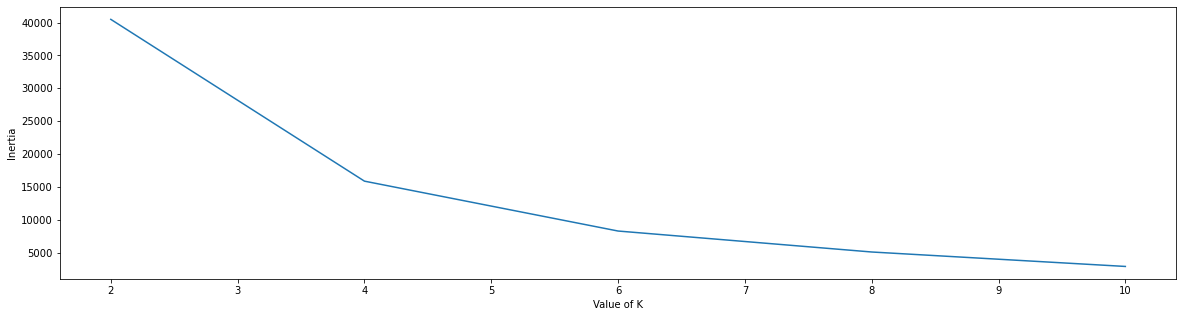

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
k = [2, 4, 6, 8, 10]
inertia = []
artists_kmeans = artists.iloc[:, 1:11]
for num in k:
    kmeans = KMeans(n_clusters=num)
    kmeans.fit(artists_kmeans)
    inertia.append(kmeans.inertia_)
    
plt.rcParams["figure.figsize"] = (20, 5)
fig, bx = plt.subplots()
bx.plot(k, inertia)
plt.xlabel('Value of K')
plt.ylabel('Inertia')
plt.show()

I would select K as "4", because above plot shows 'elbow' at K = 4

## 3 Running a Hadoop Example (10 pts)
**Follow the Tutorial-Hadoop.pdf in the iCampus and report outputs of "hdfs dfs -cat output/*" in the page 6. We note that the tutorial is updated and
please report the output without the analysis!**

2 dfs.webhdfs.enabled<br>
2 dfs.permissions.enabled<br>
2 dfs.namenode.servicerpc<br>
2 dfs.namenode.rpc<br>
2 dfs.namenode.name.dir<br>
2 dfs.namenode.https<br>
2 dfs.namenode.http<br>
2 dfs.datanode.use.datanode.hostname<br>
2 dfs.client.use.datanode.hostname<br>
1 dfsadmin<br>